# Nonparametric Inference using Control Points 
In this notebook we simulate noisy Δ14C data, from a sinusoidal production rate function, and try to recover the production rates using control points interpolated by a Gaussian Process. 

The control points are first fitted by local optimization, with objective function being the negative chi2 likelihood of the model with a GP regularization term. We then use this to initialize an MCMC sampler to quantify the uncertainties. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

import ticktack
import jax.numpy as jnp
from jax import jit
from ticktack import fitting

rcParams['figure.figsize'] = (10.0, 5.0)

## Simulating Noisy d14c data

We start by defining a parametric production rate function to simulate data for injection and recovery. For this example, we use a sinusoid with a 11-year period. In the next cell, the attributes for a `CarbonFitter` have been defined explicitly. In practice, one can just call `cf.load_data(filename.csv)`, provided the csv file is in the required structure (see example csv file).

In [2]:
@jit
def sine(t):
    prod =  1.87 + 0.7 * 1.87 * jnp.sin(2 * jnp.pi / 11 * t + jnp.pi/2)
    prod = prod * (t>=cf.start) + (1.87 + 0.7 * 1.87 * jnp.sin(2 * jnp.pi / 11 * cf.start + jnp.pi/2)) * (1-(t>=cf.start))
    return prod

In [3]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.prepare_function(custom_function=True, f=sine)
cf.time_data = jnp.arange(200, 230) 
cf.d14c_data_error = jnp.ones((cf.time_data.size,))
cf.start = np.nanmin(cf.time_data)
cf.end = np.nanmax(cf.time_data)
cf.resolution = 1000
cf.burn_in_time = jnp.linspace(cf.start-1000, cf.start, cf.resolution)
cf.time_grid_fine = jnp.arange(cf.start, cf.end, 0.05)
cf.time_oversample = 1000
cf.offset = 0
cf.gp = True
cf.annual = jnp.arange(cf.start, cf.end + 1)
cf.mask = jnp.in1d(cf.annual, cf.time_data)[:-1]

Visualizing true d14c data and noisy d14c data. Adding unit gaussian noise on the d14c data gives SNR ~10.

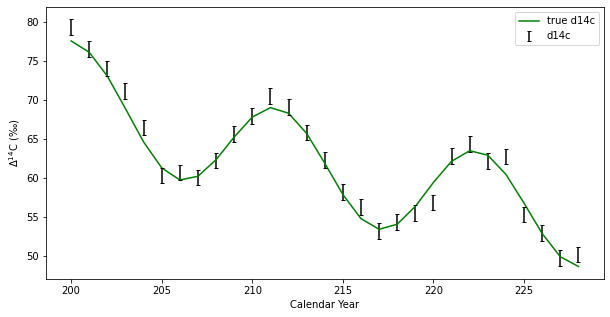

In [4]:
np.random.seed(0)
d14c = cf.dc14()
noisy_d14c = np.array(d14c) + np.random.randn(d14c.size) # add unit gaussian noise
noisy_d14c = np.append(noisy_d14c, noisy_d14c[-1]) # for compatibility with ticktack code
plt.plot(cf.time_data[:-1], d14c, "-g", label="true d14c", markersize=10)
plt.errorbar(cf.time_data[:-1], noisy_d14c[:-1], yerr=cf.d14c_data_error[:-1], 
             fmt="k", linestyle='none', fillstyle="none", capsize=2, label="d14c")
plt.ylabel("$\Delta^{14}$C (‰)")
plt.xlabel("Calendar Year");
plt.legend();

Here we have the noisy d14c data stored in `cf.d14c_data`. Based on this noisy data, we want to recover the true production rate as best as we can. A non-parametric approach is using control points, which determine the shape of the production function. To avoid long runtime, we use only one control point per 2 years. 

In [5]:
cf.d14c_data = jnp.array(noisy_d14c)
cf.prepare_function(use_control_points=True, interp='gp')
cf.control_points_time = jnp.arange(cf.start, cf.end, 2)
print("%d years in the period, %d control-points used" % (cf.annual.size, cf.control_points_time.size))

30 years in the period, 15 control-points used


Fitting the control points using the L-BFGS-B method from `scipy.minimize.optimize`,

In [6]:
%%time
soln = cf.fit_cp(low_bound=0.)

CPU times: user 1min 34s, sys: 391 ms, total: 1min 34s
Wall time: 1min 32s


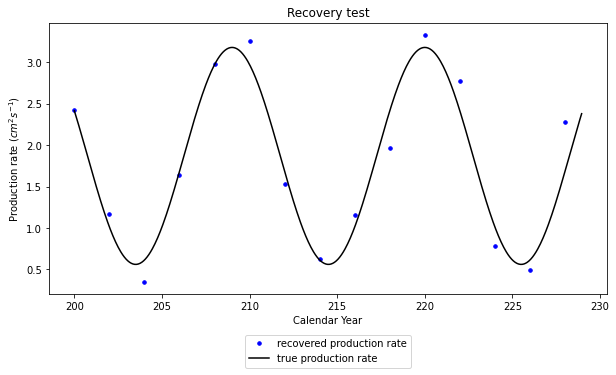

In [7]:
plt.plot(cf.control_points_time, soln.x, ".b", markersize=7, label="recovered production rate")
plt.plot(cf.time_grid_fine, sine(cf.time_grid_fine), 'k', label='true production rate')
plt.title("Recovery test");
plt.ylabel("Production rate ($cm^2s^{-1}$)");
plt.xlabel("Calendar Year");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True)

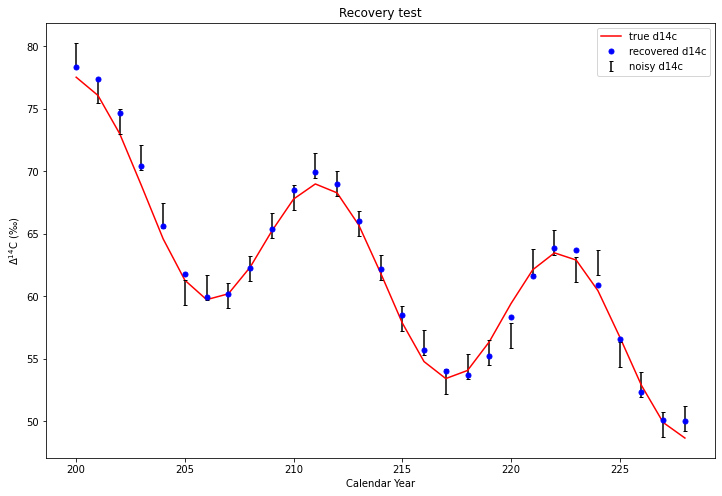

In [8]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(cf.time_data[:-1], d14c, "-r", label="true d14c", markersize=10)
plt.errorbar(cf.time_data[:-1], noisy_d14c[:-1], yerr=cf.d14c_data_error[:-1], 
             fmt="k", linestyle='none', fillstyle="none", capsize=2, label="noisy d14c")
plt.plot(cf.time_data[:-1], cf.dc14(soln.x), ".b", label="recovered d14c", markersize=10)
plt.title("Recovery test");
plt.ylabel("$\Delta^{14}$C (‰)");
plt.xlabel("Calendar Year");
plt.legend(fancybox=True)

We now use MCMC to sample the posterior distribution for the control points using the affine-invariant sampler `emcee`:

In [9]:
sampler = cf.sampling(soln.x, cf.gp_likelihood, burnin=500, production=1000)

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [03:40<00:00,  2.27it/s]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:20<00:00,  2.27it/s]


Let's visualize the diversity of samples and quantify the uncertainty on our fitted production rate. We do pretty well! 

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.11it/s]


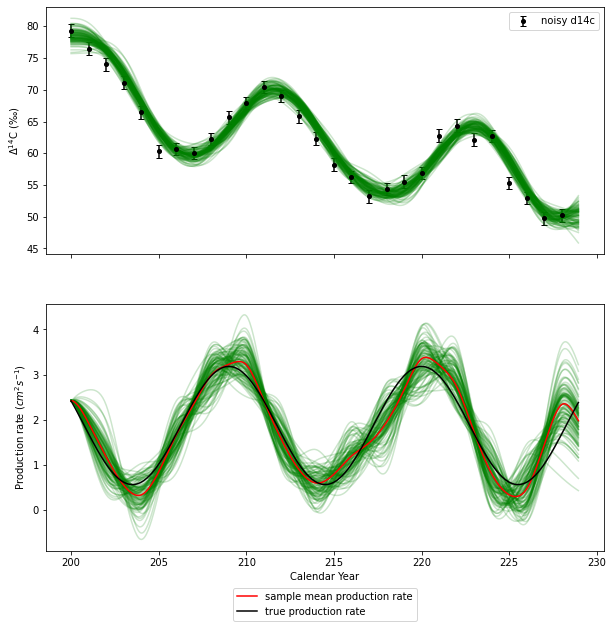

In [10]:
cf.plot_recovery(sampler, time_data=cf.time_grid_fine, true_production=sine(cf.time_grid_fine))